# Lab 1: Exploring Table Data

Chandler Burke

Yifan Ding

Owen Lin

Xuechen Li

# Business Understanding (15 Points Total)

This dataset, “Chess Game Dataset Lichess,” is obtained from Kaggle under the CC0: Public Domain license.  Lichess.org is a website where users can play live chess games; the information in the dataset contains information from approximately 21,000 games and includes variables such as outcome (white win, black win, or draw), chess rating for black and white, moves (which allows for a complete record of the game), and time increment.  Lichess has an API which allows for relatively easy collection of the data.

Among the questions that can be explored using this dataset include: (1) “What (if any) is the white advantage given relative ratings and opening position?”, (2) “What are the best moves after a specific opening that lead to victory?”, (3) “Will this position result in a draw?”, and (4) “Who is going to win after the opening?”  The white advantage question can be answered with data visualization.  The best moves question is best answered with a chess engine such as Stockfish.  The draw question is a probability question.  

For this assignment, our question is “Who is most likely to win the game after 5 moves (10 half-moves) of a chess game?”

The prediction task is to predict the winner of a chess match while it is on-going.  The model will be given the metadata of the match, the type of opening, and the first ten half moves of a chess game.  The most obvious use for our data is by gambling websites to set true odds of matches or, alternatively, by individual gamblers to find attractive bets.  The “while on-going” is because many websites are starting to implement live gambling.  If this innovation comes to chess, than similar models will become necessary by gambling websites to update the true odds of who will win.  While the data was compiled on Lichess.com with its own rating system, our model could on any game where the ratings of the players come from the FIDE (International Chess Federation), USCF (United States Chess Federation), and the popular website Chess.Com as these ratings are highly correlated.  We know this because there even exists a rating comparison site, https://chessgoals.com/rating-comparison/, that can be used to convert between Lichess.com, Chess.com, FIDE, and USCF chess ratings.  Thus, if a gambler knows the maximum time of the match, a viable chess rating for black or white, and the opening ten moves—he should be able to predict who will win.  If a real-time betting site exists, he will have an idea of whether to make a bet.  Or alternatively, the gambling website will be able to update the true odds so that the website can make money.

Our model would be helpful if knowing the opening ten moves, which player is white, and the time increment (how much time was allowed on the chess clock) provides useful information beyond just the rating of the player.  Using just the rating, there is a formula which predicts who should win the match.  From Wikipedia, the formula for an ELO rating system is as follows: 

$$
P_{white} + \frac{1}{2}P_{draw}= \frac{1}{1+10^{\frac{black_{rating}-white_{rating}}{400}}}
$$

 
Where $P_{white}$ is the probability that white will win, $P_{draw}$ is the probability of a draw, $black_{rating}$ is the rating of black under FIDE, and $white_{rating}$ is the rating of white under FIDE.  Note that the rating formula is only taken for FIDE, as FIDE uses the ELO rating formula.  The rating system for Lichess.com uses the Glicko-2 rating system.  As mentioned above, however, these rating systems are highly correlated and thus can be converted between one another with a technique like linear regression.

For example, if is there a 200 point difference between two players, the higher rated player is expected to win approximately 75% of the available points ($P_{win}$ + 1/2 $P_{draw}$).  Note that this formula does not know the draw probability and does not attempt to find it. However, we can estimate the $P_{draw}$  as the sample $P_{draw}$ of 4.74%.  Plugging $P_{draw}$ into the equation we can write a formula that predicts the probability of a white win, probability of a black win, and probability of a draw based only on the rating.  

$$
P_{white} = \frac{1}{1+10^{\frac{black_{rating}-white_{rating}}{400}}}-0.024
$$

$$
P_{black} = \frac{1}{1+10^{\frac{white_{rating}-black_{rating}}{400}}}-0.024
$$

$$
P_{draw} = 0.048
$$

Using these three formulas, we can create a classifier that predicts $P_{white}$, $P_{black}$, and $P_{draw}$ based on which probability is larger.  Our model is trying to be better than this simple classifier. 

We can write a more sophisticated predictor for $P_{draw}$ as $P_{draw}$ depends on both the average ratings of the player and the absolute value of the difference of the ratings.  The average rating of the player is positively correlated with $P_{draw}$, while the absolute value of the difference is negatively correlated with $P_{draw}$.  The following graph is from chess-db.com which is a database which includes over eight million chess games. From the graph below, you can see that the slope is negative($P_{draw}$ decreases as the difference increases) and that higher lines have higher average ratings(better players have a higher $P_{draw}$ overall.<img src="draw_vs_rating.PNG">

https://chess-db.com/public/research/draw_rate.html

Last, we see that Pdraw is much higher overall than it is for lichess.com.  This can probably be explained by how serious the players are taking the game—lichess.com probably has many people who are playing casually—which will result in a lower draw rate than a draw rate under different circumstances.

## Citations for Business Understanding

En.wikipedia.org. (2019). Chess notation. [online] Available at: https://en.wikipedia.org/wiki/Chess_notation [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). Chess rating system. [online] Available at: https://en.wikipedia.org/wiki/Chess_rating_system [Accessed 14 Sep. 2019].

Chess-db.com. (2019). Draw Rate in Chess Tournaments. [online] Available at: https://chess-db.com/public/research/draw_rate.html [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). Elo rating system. [online] Available at: https://en.wikipedia.org/wiki/Elo_rating_system [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). First-move advantage in chess. [online] Available at: https://en.wikipedia.org/wiki/First-move_advantage_in_chess [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). List of chess openings. [online] Available at: https://en.wikipedia.org/wiki/List_of_chess_openings [Accessed 14 Sep. 2019].

# Data Understanding (30 Points Total)

## Define Data Types (15 Points)

### Reading in File

In [1]:
# Reading Data from CSV with Pandas
import pandas as pd
import numpy as np

def get_csv_from_file(file):
    '''
    Input: file name
    Output: csv of file
    '''
    with open(file) as f:
       csv1 = pd.read_csv(f)
    return csv1

# original dataset is from https://www.kaggle.com/datasnaek/chess
file = '/Users/chandlerjburke/Desktop/games.csv'
chess_original = get_csv_from_file(file)
chess_pd = pd.read_csv(file)
chess_tsne = pd.read_csv(file) # we will add one-hot encoding to a dataframe used for TSNE

def remove_feature(dataframe, feature):
    '''
    Input: dataframe, feature to remove
    Output: dataframe without feature
    '''
    if feature in dataframe:
        dataframe = dataframe.drop(feature, axis = 1)
    return dataframe

def add_feature(df, name, data):
    '''
    Input: dataframe, name of feaure, data
    Ouput: dataframe with feature added
    '''
    df[name] = data
    return df

def one_hot_encode(df, name, cat_columns):
    '''
    Input: dataframe, name of feaure, categories of the column
    Output: dataframe with one hot encoded feature added
    '''
    if name in df:
        name = pd.get_dummies(df[name],prefix_sep='_',columns=cat_columns)
    return name

#Preview the first five lines of the data
#chess_original.head()

## Remove Unnecessary Variables

In [2]:
# Print Original data types
print(chess_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
id                20058 non-null object
rated             20058 non-null bool
created_at        20058 non-null float64
last_move_at      20058 non-null float64
turns             20058 non-null int64
victory_status    20058 non-null object
winner            20058 non-null object
increment_code    20058 non-null object
white_id          20058 non-null object
white_rating      20058 non-null int64
black_id          20058 non-null object
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_name      20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB
None


In [3]:
#We will get rid of id(id of game,white id and black id) as these names are not necessary for prediction
chess_pd = remove_feature(chess_pd, 'id') 
chess_pd = remove_feature(chess_pd, 'white_id') 
chess_pd = remove_feature(chess_pd, 'black_id')

chess_tsne = remove_feature(chess_tsne, 'id')
chess_tsne = remove_feature(chess_tsne, 'white_id') 
chess_tsne = remove_feature(chess_tsne, 'black_id')

#For 'opening_eco' and 'opening_name', We will only use 'opening_eco' and drop opening_name
chess_pd = remove_feature(chess_pd, 'opening_name')

chess_tsne = remove_feature(chess_tsne, 'opening_name')

#chess_pd.head()  #verify features have been removed

In [4]:
#Created at and last move at are not known at time of prediction part-way through the game
chess_pd = remove_feature(chess_pd, 'created_at')
chess_pd = remove_feature(chess_pd, 'last_move_at')

chess_tsne = remove_feature(chess_tsne, 'created_at')
chess_tsne = remove_feature(chess_tsne, 'last_move_at')
#chess_pd.head()  #verify features have been removed

In [5]:
#victory_status not known at time of prediction
chess_pd = remove_feature(chess_pd, 'victory_status')

chess_tsne = remove_feature(chess_tsne, 'victory_status')


In [6]:
# Verify variables have been removed from working copy
print(chess_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
rated             20058 non-null bool
turns             20058 non-null int64
winner            20058 non-null object
increment_code    20058 non-null object
white_rating      20058 non-null int64
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), int64(4), object(4)
memory usage: 1.2+ MB
None


In [7]:
print(chess_tsne.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
rated             20058 non-null bool
turns             20058 non-null int64
winner            20058 non-null object
increment_code    20058 non-null object
white_rating      20058 non-null int64
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), int64(4), object(4)
memory usage: 1.2+ MB
None


### Rated Variable Type

Rated variable: Whether the game result will affect the players' rating score. For not rated games, the result will not be recorded. The 'Rated' variable matters since the player will be more motivated to win the game. Our hypothesis is that rated games are treated seriously--so there will be fewer upsets.

In [8]:
#From above 'rated' is a boolean. For True is a rated game while False is non-rated.
print('Rated should be a boolean: ' + str(type(chess_pd.rated[0])))

# Rated should be one-hot encoded for chess_tsne

rated_dummy = one_hot_encode(chess_pd, 'rated' , [True, False])
chess_tsne = pd.concat([chess_tsne, rated_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'rated')
#print(chess_tsne.head())

#print(chess_tsne)

Rated should be a boolean: <class 'numpy.bool_'>


### Winner Variable Type
Winner Variable: The winner variable represents whether the outcome of the game is a white win, black win, or a draw. Since white will move first in a chess game, white is traditionaly considered to have a small advantage over black. A draw is a tie and probbaly occurs between players with similar ratings. This is the feature that we are trying to predict: White, Black, or Draw.  This is a categorical variable that will be represented by integers.

In [9]:
###From above the winner is a categorical
print('Original data type is a string: ' + str(type(chess_pd.winner[0]))) #Str

#So convert to categorical
chess_pd.winner = pd.Categorical(chess_pd.winner)

#check if it is categorical
print('New data type is category: ' + str(type(chess_pd.winner[0]))) 

# Winner should be one-hot encoded for chess_tsne 

#chess_tsne=add_feature(chess_tsne,pd.get_dummies(chess_pd.winner,prefix_sep="_",columns=cat_columns))
#print(chess_tsne)

cat_columns=["white","black","draw"]
winner_dummy = one_hot_encode(chess_pd, 'winner' , cat_columns)
chess_tsne = pd.concat([chess_tsne, winner_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'winner')
#print(chess_tsne.head())

Original data type is a string: <class 'str'>
New data type is category: <class 'str'>


### White Rating Variable Type
White Rating Variable: The White Rating variable is a rating score that reflects the performance of a player when playing in rated chess games versus other players. It is an estimate of a person's tournament playing strength. A higher Rating Variable means the player usually have a better performance. Obviously, this variable will be correlated with the outcome.

In [10]:
###From above the White Rating is a ordinal
print('White Rating is an integer: ' + str(type(chess_pd.white_rating[0]))) 


White Rating is an integer: <class 'numpy.int64'>


### Black Rating Variable Type
Black Rating Variable: The Black Rating variable is a rating score that reflects the performance of a player when playing in rated chess games versus other players. It is an estimate of a person's tournament playing strength. A higher Rating Variable means the player usually have a better performance. Obviously, this variable will be correlated with the outcome.

In [11]:
###From above the Black Rating is a ordinal
print('Black rating is an integer: ' + str(type(chess_pd.black_rating[0]))) 

Black rating is an integer: <class 'numpy.int64'>


### First 10 Moves
Moves- First 10 moves variable: This variable consistes of a list of strings that records the first ten moves of a game. Our prediction is to predict the outcome after the first ten moves. 

In [12]:
#To Use moves, we would use the first ten moves to predict the win and lose

total_moves = chess_pd.moves

def moves():
    '''
    Input: none
    Output a list of moves
    '''
    move_record=[]
    count=0
    for count in range(len(total_moves)):
        move_split=total_moves[count].split(" ")
        move_record.append(move_split)
    return np.array(move_record)


In [13]:
def number_of_moves(all_moves, x):
    '''
    Input:
    moves_list is the list of moves as string
    x is number of moves you want to keep
    Output: list of moves up to x
    '''
    moves_given = []
    for idx, all_moves in enumerate(all_moves):
        # Output up to x
        if len(all_moves) > x :
            moves_given.append(all_moves[0:x])
        # Output entire game
        else:
            moves_given.append(all_moves)
    return moves_given

move_list = moves()
#print(move_list)
ten_moves = number_of_moves(move_list, 10)
#print(ten_moves)

### Add ten moves to dataframe

In [14]:
chess_pd = add_feature(chess_pd, 'ten_moves', ten_moves)

In [15]:
###From above the moves is a list of strings
outer_object = str(type(chess_pd.ten_moves[0]))
inner_object = str(type(chess_pd.ten_moves[0][0]))

print('Moves is a list of strings: ' + outer_object + ' ' + inner_object) 

Moves is a list of strings: <class 'list'> <class 'str'>


### Remove all moves from TSNE

In [16]:
chess_tsne = remove_feature(chess_tsne, 'moves')

### Opening_eco
Opening_eco variable: This variable corresponds with a specific kind of the opening for a chess game. We will skip the opening_name since the opening eco is a classification of the opening name. There are 365 different types of openings in the sample of 20,058 games.  There are three portions of a chess game: the opening, the midgame, and the endgame. There exists a field of study that is just opening plays in a chess game and at the higher levels of chess these openings are scripted.  Furthermore, some openings are open and some are closed and it is quite probable that closed openings result in more draws than dynamic openings. 


In [17]:
###From above the Opening_eco is a categorical, but we cannot one hot encoding because there are too many types
#print(chess_pd.opening_eco.value_counts())

print('opening_eco is a string: ' +  str(type(chess_pd.opening_eco[0])))

# remove from chess_tsne as 365 is too large for opening eco
chess_tsne = remove_feature(chess_tsne, 'opening_eco')


opening_eco is a string: <class 'str'>


## Feature Engineering

### Classify Openings as one of five Types:
A: Flank Openings

B: Semi-Open Games

C: Open Games and French Defence

D: Closed Games and Semi-Closed Games

E: Indian Defence

Since there are five different kinds of openings, we will use [A, B, C, D, E] instead of the original categories of the opening_eco.  This categorical variable will be used for visualization and potentially as an input into a ML algorithm.

######  Classifications are the same as those described in the "List of Chess Openings" on Wikipedia

In [18]:
#For opening moves, we will only use ABCDE to classify it

def count_all_opening(opening_codes):
    '''
    Input: The opening type of the game
    Output: Count the number of opening types
    '''
    opening_dict = {}
    for opening in opening_codes:
        if opening in opening_dict:
            opening_dict[opening] += 1
        else:
            opening_dict[opening] = 1
    return len(opening_dict.keys())

count_opening = count_all_opening(chess_pd['opening_eco'])
print('There are ' + str(count_opening) + ' openings')

There are 365 openings


In [19]:
def classify_opening_moves(dataframe,opening_eco):
    '''
    Input: the dataframe you use and the opening type of the game
    Output: The opening type with only ABCDE cla
    '''
    opening_class = []
    for opening in dataframe.opening_eco:
        opening_class.append(opening[0])       
    return opening_class

opening_category = classify_opening_moves(chess_pd, 'opening_eco')
#Add column in dataframe from list

### Add opening_category

In [20]:
chess_pd = add_feature(chess_pd, 'opening_category', opening_category) 

chess_tsne = add_feature(chess_tsne, 'opening_category', opening_category)

In [21]:
# opening category is of type string
print('opening_category is a string: ' +  str(type(chess_pd.opening_category[0])))

# add opening category to chess_tsne
cat_columns=["A","B","C", 'D', 'E']
winner_dummy = one_hot_encode(chess_tsne, 'opening_category' , cat_columns)
chess_tsne = pd.concat([chess_tsne, winner_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'opening_category')
#print(chess_tsne.head())

opening_category is a string: <class 'str'>


### Create a Base, Increment, Maxtime

Increment code: In the form of XX+YY where XX is number in minutes and YY is the increment in seconds.  
Base: The amount of time in minutes that is on the chess clock. We will use an integer.
Increment: The seconds added to chess clock after each move. We wil use an integer.

In order to normalize the above data into one variable that can be visualized and potentially used by the ML algorithm, we combine Base and Increment into a new variable 'Maxtime.'  A chess clock is used to add stress and, in some sense, puts a maximum time on the chess match.  Thus, we can find the maximum time for the average chess match by the following equation:  

$$Maxtime = Base + \frac{mean(turns)*Increment}{60}$$

For Maxtime we will use a float.

In [22]:
def get_base(increment_code):
    '''
    input:increment_code
    output:base
    '''
    base = []
    for clock in increment_code:
        minutes, seconds = clock.split("+")
        base.append(int(minutes))
    return base

base = get_base(chess_pd.increment_code)
chess_pd = add_feature(chess_pd,'base',base)
chess_tsne = add_feature(chess_tsne, 'base', base)

# Base is a category of type string
print('base is an integer: ' +  str(type(chess_pd.base[0])))


base is an integer: <class 'numpy.int64'>


In [23]:
def get_increment(increment_code):
    '''
    input:increment_code
    output:increment
    '''
    increment = []
    for clock in increment_code:
        minutes, seconds = clock.split("+")
        increment.append(int(seconds))
    return increment

increment = get_increment(chess_pd.increment_code)
chess_pd = add_feature(chess_pd,'increment',increment)
chess_tsne = add_feature(chess_tsne, 'increment', increment)

# Increment is a category of type integer
print('base is an integer: ' +  str(type(chess_pd.increment[0])))

base is an integer: <class 'numpy.int64'>


In [24]:
import math
def get_maxtime(base, increment, num_turns):
    '''
    input:base,increment and the number of turns
    output:maxtime
    '''
    maxtime = []
    for idx, val in enumerate(base):
        maxtime_val = base[idx] + num_turns*increment[idx]/60
        maxtime_val = math.floor(maxtime_val)
        maxtime.append(maxtime_val)

    #Retain 1 decimal for maxtime
    #maxtime = list(math.floor((np.array(maxtime),1)))
    return maxtime

mean_turns = int(np.round(np.mean(chess_original.turns)))
print('The number of turns of maxtime is ' + str(mean_turns) + ' moves.' )
maxtime = get_maxtime(base, increment, mean_turns)

#Add max_time to dataframe
chess_pd = add_feature(chess_pd,'maxtime',maxtime)

# make maxtime integer
chess_tsne = add_feature(chess_tsne, 'maxtime', maxtime)

# Maxtime is a category of type float
print(' is a int: ' +  str(type(chess_pd.maxtime[0])))

The number of turns of maxtime is 60 moves.
 is a int: <class 'numpy.int64'>


### Remove Increment code from TSNEm Turns

In [25]:
chess_tsne = remove_feature(chess_tsne, 'increment_code')

### Create FIDE Linear Regression 
To find the ratings-only classifier, it is first necessary to convert to FIDE from Lichess.com.  This is because the formul relies on ELO which is used by FIDE but not Lichess.com. In this case, however, it is unnecessary to find the FIDE rating because the Classification predicter collapses to simply predicting white if the white rating is larger and black if black rating is larger.  This is largely because $P_{draw}$ is so small.  Otherwise, there would be a possibility of $P_{draw}$ if black rating and white rating were close together.  Nevertheless, we have included the linear regression below that would find the FIDE rating. However, we will not use this data elsewhere in the assignment.

### Import Data (manually copy table data)

In [26]:
# Data copied from https://chessgoals.com/rating-comparison/
lichess_bullett = [1335, 1355, 1380, 1405, 1430, 1455, 1485, 1520, \
                   1550, 1585, 1620, 1660, 1700, 1740, 1785, 1830, \
                   1875, 1925, 1975, 2025, 2080, 2135, 2190, 2245, 2305]

FIDE =            [1370, 1380, 1390, 1405, 1425, 1440, 1460, 1480, \
                   1500, 1525, 1550, 1575, 1605, 1635, 1665, 1695, \
                   1730, 1765, 1800, 1840, 1880, 1920, 1965, 2010, 2055]

### Create Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression


# Create numpy arrays
lichess_bullett = np.asmatrix(lichess_bullett)
lichess_bullett = np.transpose(lichess_bullett)
#print(lichess_bullett.shape)
FIDE = np.asarray(FIDE)

# Add bias column of 1's to X
X = lichess_bullett
X_bias = np.hstack((np.ones((len(X),1)), X))
#print(X_bias)
y = FIDE
model = LinearRegression().fit(X_bias,y)

FIDE_hat = model.predict(X_bias)

mse = np.square(np.subtract(FIDE, FIDE_hat)).mean()

print('Mean Square Error is: ' + str(mse))
print('Model Coefficients are: ' + str(model.coef_))
print('Model Intercept is: ' + str(model.intercept_))


#plot(lichess_bullett, FIDE)

Mean Square Error is: 55.43846284030775
Model Coefficients are: [0.         0.70834372]
Model Intercept is: 407.5318911749589


### Create and Add Rating Difference
From the formula that we see that there is a difference in the absolute value, so we should use the difference to measure the rating. For Rating_Difference = white_rating - black_rating.

In [28]:
Rating_Difference = chess_pd.white_rating - chess_pd.black_rating
chess_pd = add_feature(chess_pd,'Rating_Difference',Rating_Difference)

# Rating_Difference is a category of type integer
print('Rating_Difference is an integer: ' +  str(type(chess_pd.Rating_Difference[0])))

Rating_Difference is an integer: <class 'numpy.int64'>


### Create Ratings Only Classification Predicter

As mentioned in the introduction, there is a simple predicter that only takes consideration of black rating and white rating.  We will now define the predicter in code as follows to find the accuracy.



In [29]:
def p_draw(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: 0.048
    '''
    # In theory, p_draw is a function of white rating and black rating
    # For this assignment, however, we will have p_draw as sample draw rate
    return 0.048

def p_white(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: Probability of white
    '''
    denominator = 1.0+10.0**((black_rating-white_rating)/400.0)
    p_white = 1.0/denominator - p_draw(white_rating, black_rating)/2.0
    return p_white

def p_black(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: Probability of black wins
    '''
    denominator = 1.0+10.0**((white_rating-black_rating)/400.0)
    p_black = 1.0/denominator - p_draw(white_rating, black_rating)/2.0
    return p_black


def get_prediction(pwhite, pblack, pdraw):
    '''
    Input: probability of white will win, black will win, or draw
    Output: data type of largest probability (white, black, or draw)
    '''
    #prediction = []
    if (pwhite >= pblack) and (pwhite >= pdraw):
        return 'white'
    elif (pblack >= pwhite) and (pblack >= pdraw):
        return 'black'
    else:
        return 'draw'
    return prediction

    
def get_simple_prediction(white_rating, black_rating):
    '''
    Input: list of white rating, list of black rating, probability of draw,
    actual outcome
    Output: list of simple predictions
    '''
    simple_prediction = []
    for i ,val in enumerate(white_rating):
        pwhite = p_white(white_rating[i], black_rating[i])
        pblack = p_black(white_rating[i], black_rating[i])
        pdraw = p_draw(white_rating[i], black_rating[i])
        
        predict = get_prediction(pwhite, pblack, pdraw)
        simple_prediction.append(predict)
    return simple_prediction
        
def get_accuracy(prediction, actual):
    '''
    Input: list of predictions, list of outcomes
    Output: accuracy in decimal
    '''
    num_correct = 0
    num_total = 0
    for idx, val in enumerate(prediction):
        if prediction[idx] == actual[idx]:
            num_correct += 1
            num_total += 1
        else:
            num_total += 1
    return num_correct / num_total
    
simple_prediction = get_simple_prediction(chess_pd.white_rating, chess_pd.black_rating)
simple_accuracy = get_accuracy(simple_prediction, chess_pd.winner)

print('The accuracy of the ratings-only classifier is: ' + str(simple_accuracy))

The accuracy of the ratings-only classifier is: 0.6205504038288961


### Add Ratings Only Classifier Predictions


In [30]:
chess_pd = add_feature(chess_pd,'Ratings_Only_Prediction', simple_prediction)

# Don't add ratings only classifier to tsne


print('Ratings_Only_Prediction is a string: ' +  str(type(chess_pd.Ratings_Only_Prediction[0])))

Ratings_Only_Prediction is a string: <class 'str'>


## Data Quality (15 Points)

### Filter out Turns less than 10

If the game has less than 10 turns, it will end after 10 moves. Since we want to predict the result after first 10 moves, we have to filter out turns that less than 10.

In [31]:
def filter_short_games(df, name, num_turns):
    '''
    Input:dataframe, name of feature turns, number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name] > num_turns]
    return df

chess_pd = filter_short_games(chess_pd, 'turns', 10)
chess_tsne = filter_short_games(chess_tsne, 'turns', 10)
chess_tsne = remove_feature(chess_tsne, 'turns')

print('Original number of games: ' + str(len(chess_original.rated)))
print('New number of games: ' + str(len(chess_pd.rated)))

Original number of games: 20058
New number of games: 19377


### Filter out Openings longer than 10

If the opening is longer than 10 moves, it may not be possible to classify.  Also, the scripted opening may not provide any value to the ML algorithm. Thus as a precuation, we will filter out all games where the opening lasts longer than the given input.


In [32]:
def filter_long_opening(df, name, num_turns):
    '''
    Input:dataframe,number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name]<num_turns]
    return df

#chess_pd = chess_pd[-chess_pd['opening_ply']>10]
chess_pd = filter_long_opening(chess_pd, 'opening_ply', 10) 
chess_tsne = filter_long_opening(chess_tsne, 'opening_ply', 10)
print('Original number of games: ' + str(len(chess_original.rated)))
print('New number of games: ' + str(len(chess_pd.rated)))
print('New number of games: ' + str(len(chess_tsne.white_rating)))


Original number of games: 20058
New number of games: 18047
New number of games: 18047


In [33]:

chess_pd_2 = chess_pd[chess_pd['opening_ply'] > 10]
print(chess_pd_2['opening_ply'])
#print(count_all_opening(chess_pd_2['ten_moves']))

Series([], Name: opening_ply, dtype: int64)


### Examine Missing Data using Missingno


In [34]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [35]:
# This code is taken from course notebook 
import missingno as mn
mn.matrix(chess_original.sort_values(by=["id",]))

To understand the data, the first thing to do would be to check whether there is any "NA" in the dataset. Based on the plot above, there is no missing value in the data, which is ideal for analysis.

# Data Visualization (45 Points Total)

## Attribute Distributions (20 Points, at least 5)

### Rated Feature Bar Plot

Text(0.5, 1.0, 'Distribution of Rated')

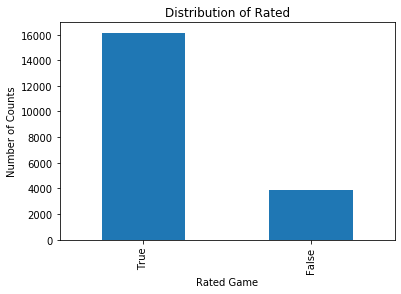

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

chess_original['rated'].value_counts().plot.bar()
plt.xlabel("Rated Game")
plt.ylabel("Number of Counts")
plt.title('Distribution of Rated')

A bar plot of the counts of rated and unrated games is poltted to see how many rated and unrated games are recorded in the dataset. We are expecting more rated game, because it is obvious that the players are treated rated game more serious since they are related to personal ranking. The final goal of this analysis it to predict who is going to win, so we need as much data of how the players would normally play as possible.

winner  black  draw  white
rated                     
False    1723   231   1949
True     7384   719   8052


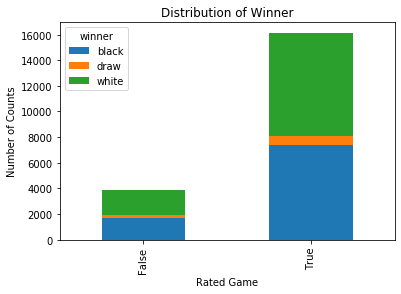

In [37]:
# This code is taken from course notebook 
win = pd.crosstab(chess_original['rated'], chess_original['winner'])
print(win)
win.plot(kind='bar', stacked=True)
plt.xlabel("Rated Game")
plt.ylabel("Number of Counts")
plt.title('Distribution of Winner')
plt.show() 

Then, we will look into the data a little deeper to see the portion of winner in these games. According to the bar chart above, white players have more wins than black players. That meets the common knowledge of chess game that white side has a small advantage in the game.

### Turns Bar Plot with Curve-Fit

Text(0.5, 1.0, 'Frequency of Turns')

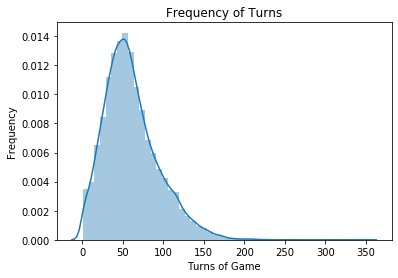

In [38]:
sns.distplot(chess_original['turns'])
plt.xlabel('Turns of Game')
plt.ylabel('Frequency')
plt.title('Frequency of Turns')

From the "Frequency of Turns" plots, we can see that it is a right-skewed distribution. The games with 55 turns have the highest appear frequency, and almost all the games end before having 150 moves.

### Victory Status Pie Chart

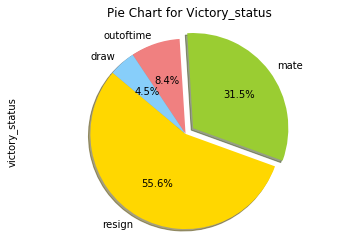

In [39]:
# This code is taken from website
#https://pythonspot.com/matplotlib-pie-chart/
#Took code for colors and shape of the pie chart
explode = (0, 0.1, 0, 0)
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
chess_original['victory_status'].value_counts().plot.pie(explode=explode, colors=colors, 
              autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Pie Chart for Victory_status')
plt.show()

The pie chart of "victory_status" indicates that more than half of the games are ended with the move "resign" (55.6%). The move "mate" comes the second, with 31.5%. 

### White Rating Distribution

Text(0.5, 1.0, 'Distribution of white_rating')

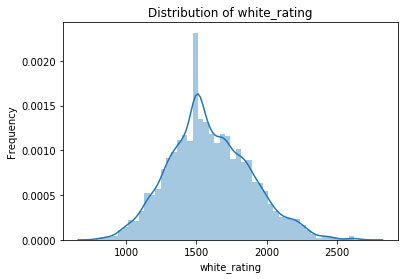

In [40]:
#Distribution of white_rating
sns.distplot(chess_original['white_rating'])
plt.xlabel('white_rating')
plt.ylabel('Frequency')
plt.title('Distribution of white_rating')

The distribution of "white_rating" is close to a normal distribution. As we can see, most of the player has their rating in the range between 1000 and 2300. 

### Black Rating Distribution

Text(0.5, 1.0, 'Distribution of black_rating')

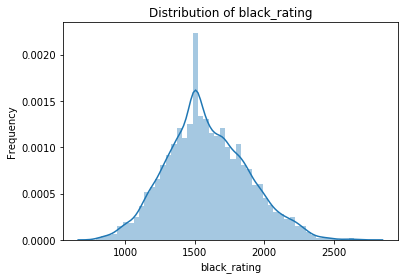

In [41]:
#Distribution of black_rating
sns.distplot(chess_original['black_rating'])
plt.xlabel('black_rating')
plt.ylabel('Frequency')
plt.title('Distribution of black_rating')

Same as the distribution of "white_rating", distribution of "black_rating" is close to normal distribution as well. And most of the player also has their rating in the range between 1000 and 2300. 

### White Rating Win Percentage Violin Plot

In [42]:
# This code is taken from course notebook 
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

print('Seaborn:', sns. __version__)

Seaborn: 0.9.0


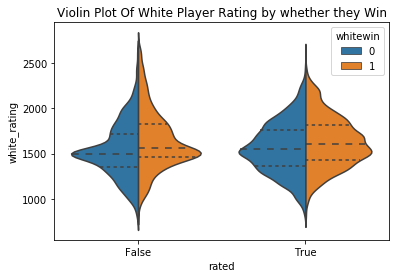

In [43]:
import math
chess_original_4 = pd.DataFrame(chess_original)
chess_original_4['whitewin'] = np.where(chess_original_4['winner'] == 'white', 1, 0)
# This code is taken from course notebook 
sns.violinplot(x="rated", y="white_rating", hue="whitewin", data=chess_original_4, 
               split=True, inner="quart")
plt.title('Violin Plot Of White Player Rating by whether they Win')
plt.show()

On this violin plot, we can find that over all white players has higher win percentage in games. However, it shows that white players with rating below 1600 are not doing as well as the high rating players. The white players with rating below 1600 are more likely that they can not win the game.

### Opening Category Bar Chart

Text(0.5, 1.0, 'Opening_category of Games')

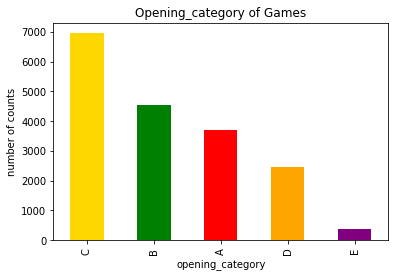

In [44]:
colors = ['gold', 'green', 'red', 'orange', 'purple']
chess_pd['opening_category'].value_counts().plot.bar(color = colors)
plt.xlabel('opening_category')
plt.ylabel('number of counts')
plt.title('Opening_category of Games')

The plot indicates that the first move under "C" of "opening_category" has the highest pick in games. And only a few players chose "E" as their opening step.

### Moves Visualization

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


def is_white(move_idx):
    '''
    Input: number
    Output: True if white, False if black 
    '''
    if (move_idx % 2 == 0):
        return True 
    else:
        return False
    
#print(is_white(4))
#print(is_white(5))

#### Helper Functions for getting Rank, File

In [46]:
def is_lowercase(character):
    '''
    Input: character
    Output: boolean
    '''
    if character.isalpha():
        if character.islower():
            return True
        else:
            return False
    else:
        return False

def is_number(character):
    '''
    Input: character
    Output: boolean
    '''
    if character.isdigit():
        return True
    else:
        return False
    
def is_identify_piece(move):
    '''
    Input: move
    Output: boolean
    '''
    letter_count = 0
    number_count = 0
    for character in move:
        if is_lowercase(character):
            letter_count += 1
        if (is_number(character)):
            number_count += 1
    if letter_count > 1 or number_count > 1:
        return True
    else:
        return False
#print(is_identify_piece('e7'))
#print(is_identify_piece('Nge7'))
#print(is_identify_piece('e1=Q'))


### Finding the Rank (row) of a Move

In [47]:
def rank_conversion(move):
    '''
    Input: a string of length 2 or 3
    Output: rank, or no data if error
    '''
    if '1' in move:
        return 1
    elif '2' in move:
        return 2
    elif '3' in move:
        return 3
    elif '4' in move:
        return 4
    elif '5' in move:
        return 5
    elif '6' in move:
        return 6
    elif '7' in move:
        return 7
    elif '8' in move:
        return 8
    # special case: promoted to Q
    else:
        #print("move" + str(move))
        return 'no_data'

#print(rank_conversion('e4'))
#print(rank_conversion('Nge7'))
#print(rank_conversion('e1=Q'))



In [48]:
def get_rank(idx, move):
    '''
    Input: number of move, move
    Output: list which includes number of the rank
    '''
    #print(idx)
    #print(move)
    # Simple move
    if (len(move) < 4) and ('O' not in move)and (len(move) > 1):
        return [rank_conversion(move)]
    # Don't know what this means
    elif(len(move) == 1):
        return "no_data"
    # promoting pawn to last rank, didn't identify pawn
    elif ('=' in move):
        if(rank_conversion(move) != 'no_data'):
            return [rank_conversion(move)]
    # Capture move
    elif ('x' in move):
        idx = move.index('x')
        return [rank_conversion(move[idx:])]
    # Kingside Castle
    elif move == 'O-O':
        if is_white(idx):
            return [1,1]
        else:
            return [8,8]
    elif move == 'O-O+':
        if is_white(idx):
            return [1,1]
        else:
            return [8,8]
    # Queenside Castle
    elif move == 'O-O-O':
        if is_white(idx):
            return [1,1] 
        else:
            return [8,8]
    elif move == 'O-O-O+':
        if is_white(idx):
            return [1,1] 
        else:
            return [8,8]
    # check or checkmate
    elif ('+' in move) or ('#' in move):
        return [rank_conversion(move[-3:])]
    #Have to identify piece (could be either knight, bishop, queen, or rook)
    elif(is_identify_piece(move)):
        return [rank_conversion(move[-2:])]
    else:
        #print(move)
        return 'no_data'
                                
#print(get_rank(0, 'e4'))
#print(get_rank(0, 'Be4'))
#print(get_rank(0, 'O-O'))
#print(get_rank(1, 'O-O'))
#print(get_rank(0, 'O-O-O'))
#print(get_rank(1, 'O-O-O'))
#print(get_rank(0, 'Nge7'))
#print(get_rank(0, 'e1=Q'))
#print(get_rank(1, 'e1=Q'))



### Find the File (Column) of a Move

In [49]:
def file_conversion(move):
    '''
    Input: a string of length 2 or 3
    Output: rank, or -1 if error
    '''
    if "a" in move:
        return 'a'
    elif "b" in move:
        return 'b'
    elif "c" in move:
        return 'c'
    elif "d" in move:
        return 'd'
    elif "e" in move:
        return 'e'
    elif "f" in move:
        return 'f'
    elif "g" in move:
        return 'g'
    elif "h" in move:
        return 'h'
    # special case: promoted to Q
    elif "Q" in move:
        return 'no_data'
    else:
        #print("move" + str(move))
        return 'no data'
    
#print(file_conversion('e4'))
#print(file_conversion('Nge7'))
#print(file_conversion('e1=Q'))



In [50]:
def get_file(idx, move):
    '''
    Input: number of move, move 
    Output: list which includes file as string
    '''
    #print(idx)
    #print(move)
    
    # simple move
    if (len(move) < 4) and ('O' not in move) and (len(move) > 1):
        return [file_conversion(move)]
    # Don't know what this means
    elif(len(move) == 1):
        return "no_data"
    # promotion
    elif ('=' in move):
        if(rank_conversion(move) != 'no_data'):
            return [file_conversion(move)]
    # capture move
    elif "x" in move:
        idx = move.index('x')
        return [file_conversion(move[idx:])]
    # kingside castle
    elif move == 'O-O':
        if is_white(idx):
            return ['f','g']
        else:
            return ['f','g']
    #kinside castle check
    elif move == 'O-O+':
        if is_white(idx):
            return ['f','g']
        else:
            return ['f','g']
    # queenside castle
    elif move == 'O-O-O':
        if is_white(idx):
            return ['c','d'] 
        else:
            return ['c','d']
    # queenside castle check
    elif move == 'O-O-O+':
        if is_white(idx):
            return ['c','d'] 
        else:
            return ['c','d'] 
    # check or checkmate
    elif ('+' in move) or ('#' in move):
        return [file_conversion(move[-3:])]
    #Have to identify piece (could be either knight)
    elif(is_identify_piece(move)):
        return [file_conversion(move[-2:])]
    else:
        #print(move)
        return 'no_data'

#print(get_file(0, 'e4'))
#print(get_file(0, 'Be4'))
#print(get_file(0, 'O-O'))
#print(get_file(1, 'O-O'))
#print(get_file(0, 'O-O-O'))
#print(get_file(1, 'O-O-O'))
#print(get_file(0, 'Nge7'))
#print(get_file(0, 'e1=Q'))
#print(get_file(1, 'e1=Q'))


### Converting Rank, File to a position on a board with White on bottom

In [51]:
def get_board_row(rank_move):
    '''
    Input: rank
    output: row where rank 8 matched to row 0
    '''
    output = []
    for move in rank_move:
        if move == 'no_data':
            return ['no_data']
        else:
            #print("move" + str(move))
            output.append(8-move)
    return output

In [52]:
                                
def get_board_column(file_move):
    '''
    Input: list of files 
    Ouput: column where a is matched to zero
    '''
    output = []
    for move in file_move:
        if  "a" == move:
            output.append(0)
        elif "b" == move:
            output.append(1)
        elif "c" == move:
            output.append(2)
        elif "d" == move:
            output.append(3)
        elif "e" == move:
            output.append(4)
        elif "f" == move:
            output.append(5)
        elif "g" == move:
            output.append(6)
        elif "h" == move:
            output.append(7)
        else:
            #print("move" + str(move))
            output.append('no_data')
    return output

### Create Matrix which has count for all moves in that space

In [53]:
def create_board(moves_list):
    '''
    Input: list of moves 
    Output: matrix which has count of all moves 
    '''
    board_array = np.zeros((8,8))

    #print(board)
    # iterate over each game
    for idx, game in enumerate(moves_list):
        # iterate over each move
        #print(game)
        for idx, move in enumerate(game):
            # Find rank and column
            rank_move = get_rank(idx, move)
            file_move = get_file(idx, move)
                
            # convert to the board
            i_list = get_board_row(rank_move)
            j_list = get_board_column(file_move)
            
            # add to count
            for i in i_list:
                #check if i exists
                for j in j_list:
                    # check if j exists
                    if (i != 'no_data') and (j != 'no_data'):
                        board_array[i,j] += 1
                    else:
                        print(move)
                        
    return board_array


In [54]:
# Make Pretty Plot
def plot_board(moves_list, title):
    '''
    Input: board
    Output: heatmap plot
    '''
    board_array = create_board(moves_list)
    row_labels = [8, 7, 6, 5, 4, 3, 2, 1]
    
    column_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    board_df = pd.DataFrame(board_array, columns = column_labels, index = row_labels)
    ax = sns.heatmap(board_df, linewidth = 0.5, square = True)
    plt.title(title)
    plt.ylabel('Rank')
    plt.xlabel('File')
    
    #plt.show()

### Classify Moves as Pawn Moves (no capture or enpassant), Back Row (no capture), or Capture
#### Note: As defined, these categories are mutually exclusive

In [55]:
#Use given_moves list to categorize moves into 3 types: pawn, capture, big_piece
#Select given_moves

def classify_moves(moves_to_classify):
    '''
    Input: moves_to_classify is a feature column of moves
    Output: list of number and coontent of pawn moves, big_pieces moves, capture moves
    '''
    pawn_num = []
    big_pieces_num = []
    captures_num = []
    
    pawn_all_games = []
    big_pieces_all_games = []
    captures_all_games = []
    
    # iterate for every game
    for moves in moves_to_classify:
        pawn_count = 0
        big_pieces_count = 0
        captures_count = 0
        
        pawn_game = []
        big_pieces_game = []
        captures_game =[]
        
        # iterate over every move
        for half_move in moves:
            # Pawn moves just have name of square
            if (len(half_move) == 2):
                pawn_count += 1
                pawn_game.append(half_move)
            # pawn moves have promotion
            elif ('=' in half_move):
                pawn_count += 1
                pawn_game.append(half_move)
            # capture moves have an 'x'
            elif ('x' in half_move):
                captures_count += 1
                captures_game.append(half_move)
            # Big pieces moves with no capture
            else:
                big_pieces_count += 1
                big_pieces_game.append(half_move)
        
        # Create count for pie chart         
        pawn_num.append(pawn_count)
        big_pieces_num.append(big_pieces_count)
        captures_num.append(captures_count)
        
        # Create moves_list for graph visualization
        pawn_all_games.append(pawn_game)
        big_pieces_all_games.append(big_pieces_game)
        captures_all_games.append(captures_game)
    
    # Create return list    
    return_list = []
    return_list.append(pawn_num)
    return_list.append(big_pieces_num)
    return_list.append(captures_num)
    return_list.append(pawn_all_games)
    return_list.append(big_pieces_all_games)
    return_list.append(captures_all_games)
        
    return return_list

# classify moves up to 10
moves_to_classify = chess_pd.ten_moves
classified_moves = classify_moves(moves_to_classify)
pawn_num = classified_moves[0]
big_pieces_num = classified_moves[1]
captures_num = classified_moves[2]
pawn_all_games = classified_moves[3]
big_pieces_all_games = classified_moves[4]
captures_all_games = classified_moves[5]


chess_pd = add_feature(chess_pd, 'pawn_num', pawn_num)
chess_pd = add_feature(chess_pd, 'big_pieces_num', big_pieces_num)
chess_pd = add_feature(chess_pd, 'captures_num', captures_num)
chess_pd = add_feature(chess_pd, 'pawn_moves', pawn_all_games)
chess_pd = add_feature(chess_pd, 'big_pieces_moves', big_pieces_all_games)
chess_pd = add_feature(chess_pd, 'captures_moves', captures_all_games)

#classify moves up to whole game 
moves_to_classify_complete = move_list
classified_moves_complete = classify_moves(moves_to_classify_complete)
pawn_num_complete = classified_moves_complete[0]
big_pieces_num_complete = classified_moves_complete[1]
captures_num_complete = classified_moves_complete[2]
pawn_all_games_complete = classified_moves_complete[3]
big_pieces_all_games_complete = classified_moves_complete[4]
captures_all_games_complete = classified_moves_complete[5]

## Pie Chart of Moves

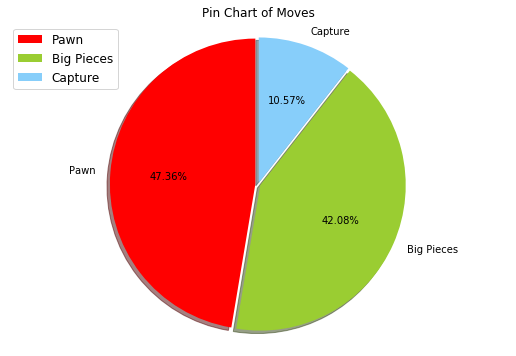

In [56]:
#Plot of Precentage of each category in given_moves
totalpawn = chess_pd.pawn_num.sum()
totalbigpieces = chess_pd.big_pieces_num.sum()
totalcaptures = chess_pd.captures_num.sum()
df = pd.DataFrame(np.array([['pawn',totalpawn],['big_pieces',totalbigpieces],['captures',totalcaptures]]),
                  columns=['moves','total'])
df.total = df.total.astype(str).astype(float)

plt.figure(figsize=(9,6))
labels = [u'Pawn',u'Big Pieces',u'Capture'] 
sizes = df.total
colors = ['red','yellowgreen','lightskyblue'] 
explode = (0.02,0.015,0.01) #Split a block, the larger the value, the larger the gap
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #Decimal
                      shadow = True, 
                      startangle =90, #Counterclockwise starting angle setting
                      pctdistance = 0.6) #Numerbers' distance from the center of the circle
plt.axis('equal')
plt.legend(loc=2, prop={'size': 12})
plt.title('Pin Chart of Moves')
plt.show()

According to the pin chart of moves, the number of Big Pieces and Pawn are nearly even.

## Moves on a Board Heatmap

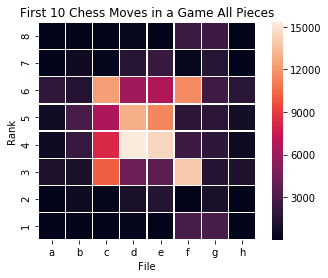

In [57]:
plot_board(moves_to_classify, "First 10 Chess Moves in a Game All Pieces")

In the above graph, white is at the bottom, black is at the top.  The lighter color is correlated with a higher frequency of moves to that space.  As we can see, most of the action in a chess game in the first 10 moves is dominated by the middle squares.  

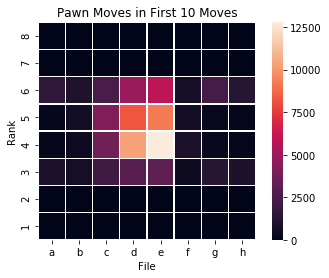

In [58]:
plot_board(pawn_all_games, "Pawn Moves in First 10 Moves")

From this graph, we can verify that the most common opening move is e4, or the pawn in front of the white king.  

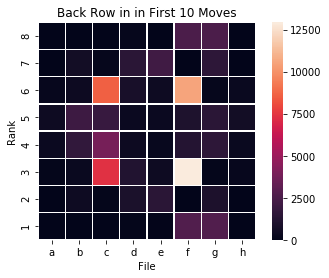

In [59]:
plot_board(big_pieces_all_games, "Back Row in in First 10 Moves")

These are the most common moves for the back-row pieces. From the graph, we can see that the most commmmon moves are to develop the knights(c3, c6, f3, f6) and we can faintly see the kingside castle (f1,g1, f8, and g8) and developing the white-kingside bishop to c4.

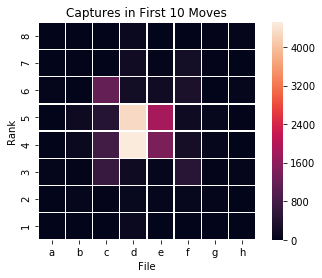

In [60]:
plot_board(captures_all_games, "Captures in First 10 Moves")

From this graph, we see that most of the captures are in the center of the board over the first 10 moves.

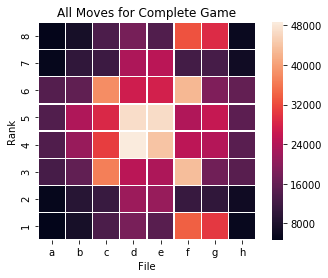

In [61]:
plot_board(move_list, "All Moves for Complete Game")

We can now more prominently see the kingside castle and the fight over the middle of the board.

[[  313.   202.   213.   179.   158.   174.   178.   219.]
 [  485.   312.   321.   359.   268.   216.   238.   340.]
 [ 7401.  4914.  6667.  8801.  9418.  4924.  6962.  7205.]
 [ 5909.  7226. 10493. 15069. 16809.  6349.  5616.  5452.]
 [ 5951.  6673.  9478. 16978. 18327.  7032.  5769.  5462.]
 [ 6346.  4602.  6908.  5952.  5226.  4570.  5364.  7233.]
 [  468.   324.   322.   333.   236.   199.   217.   339.]
 [  297.   210.   203.   169.   146.   158.   166.   209.]]


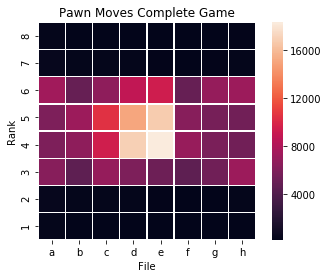

In [62]:
board_pawn_all_games = create_board(pawn_all_games_complete)
# Verify that the black in seventh rank is real
print(board_pawn_all_games)

# Verify that we are getting a count for rank 2,7
# Pawn moves in rank 7-8 are rare, promotions classified
# as back row move
plot_board(pawn_all_games_complete, "Pawn Moves Complete Game")

For this graph, we can see that it is very rare for pawns to be promoted to the back rank.  We printed out the matrix to show that the 1st, 2nd, 7th, and 8th rank exists--they are just very small. Promotion is rare.

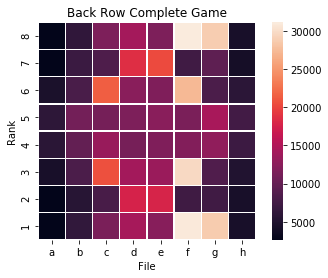

In [63]:
plot_board(big_pieces_all_games_complete, "Back Row Complete Game")

The kingside castle is the most common move for back row pieces.

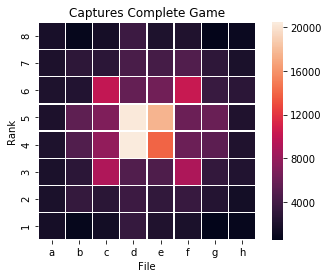

In [64]:
plot_board(captures_all_games_complete, "Captures Complete Game")

From this graph, we see that most of the captures for the complete game is very similar to captures over the first 10 moves. Sine captures are so important, the first 10 moves might be enough for a machine learning algorithm to predict who is going to win.

## Attribute Relationships (25 Points, at least 3)

## Pairwise Scatter Plots

Text(0.5, 1, 'Pairwise Scatter Plots for Chess Data')

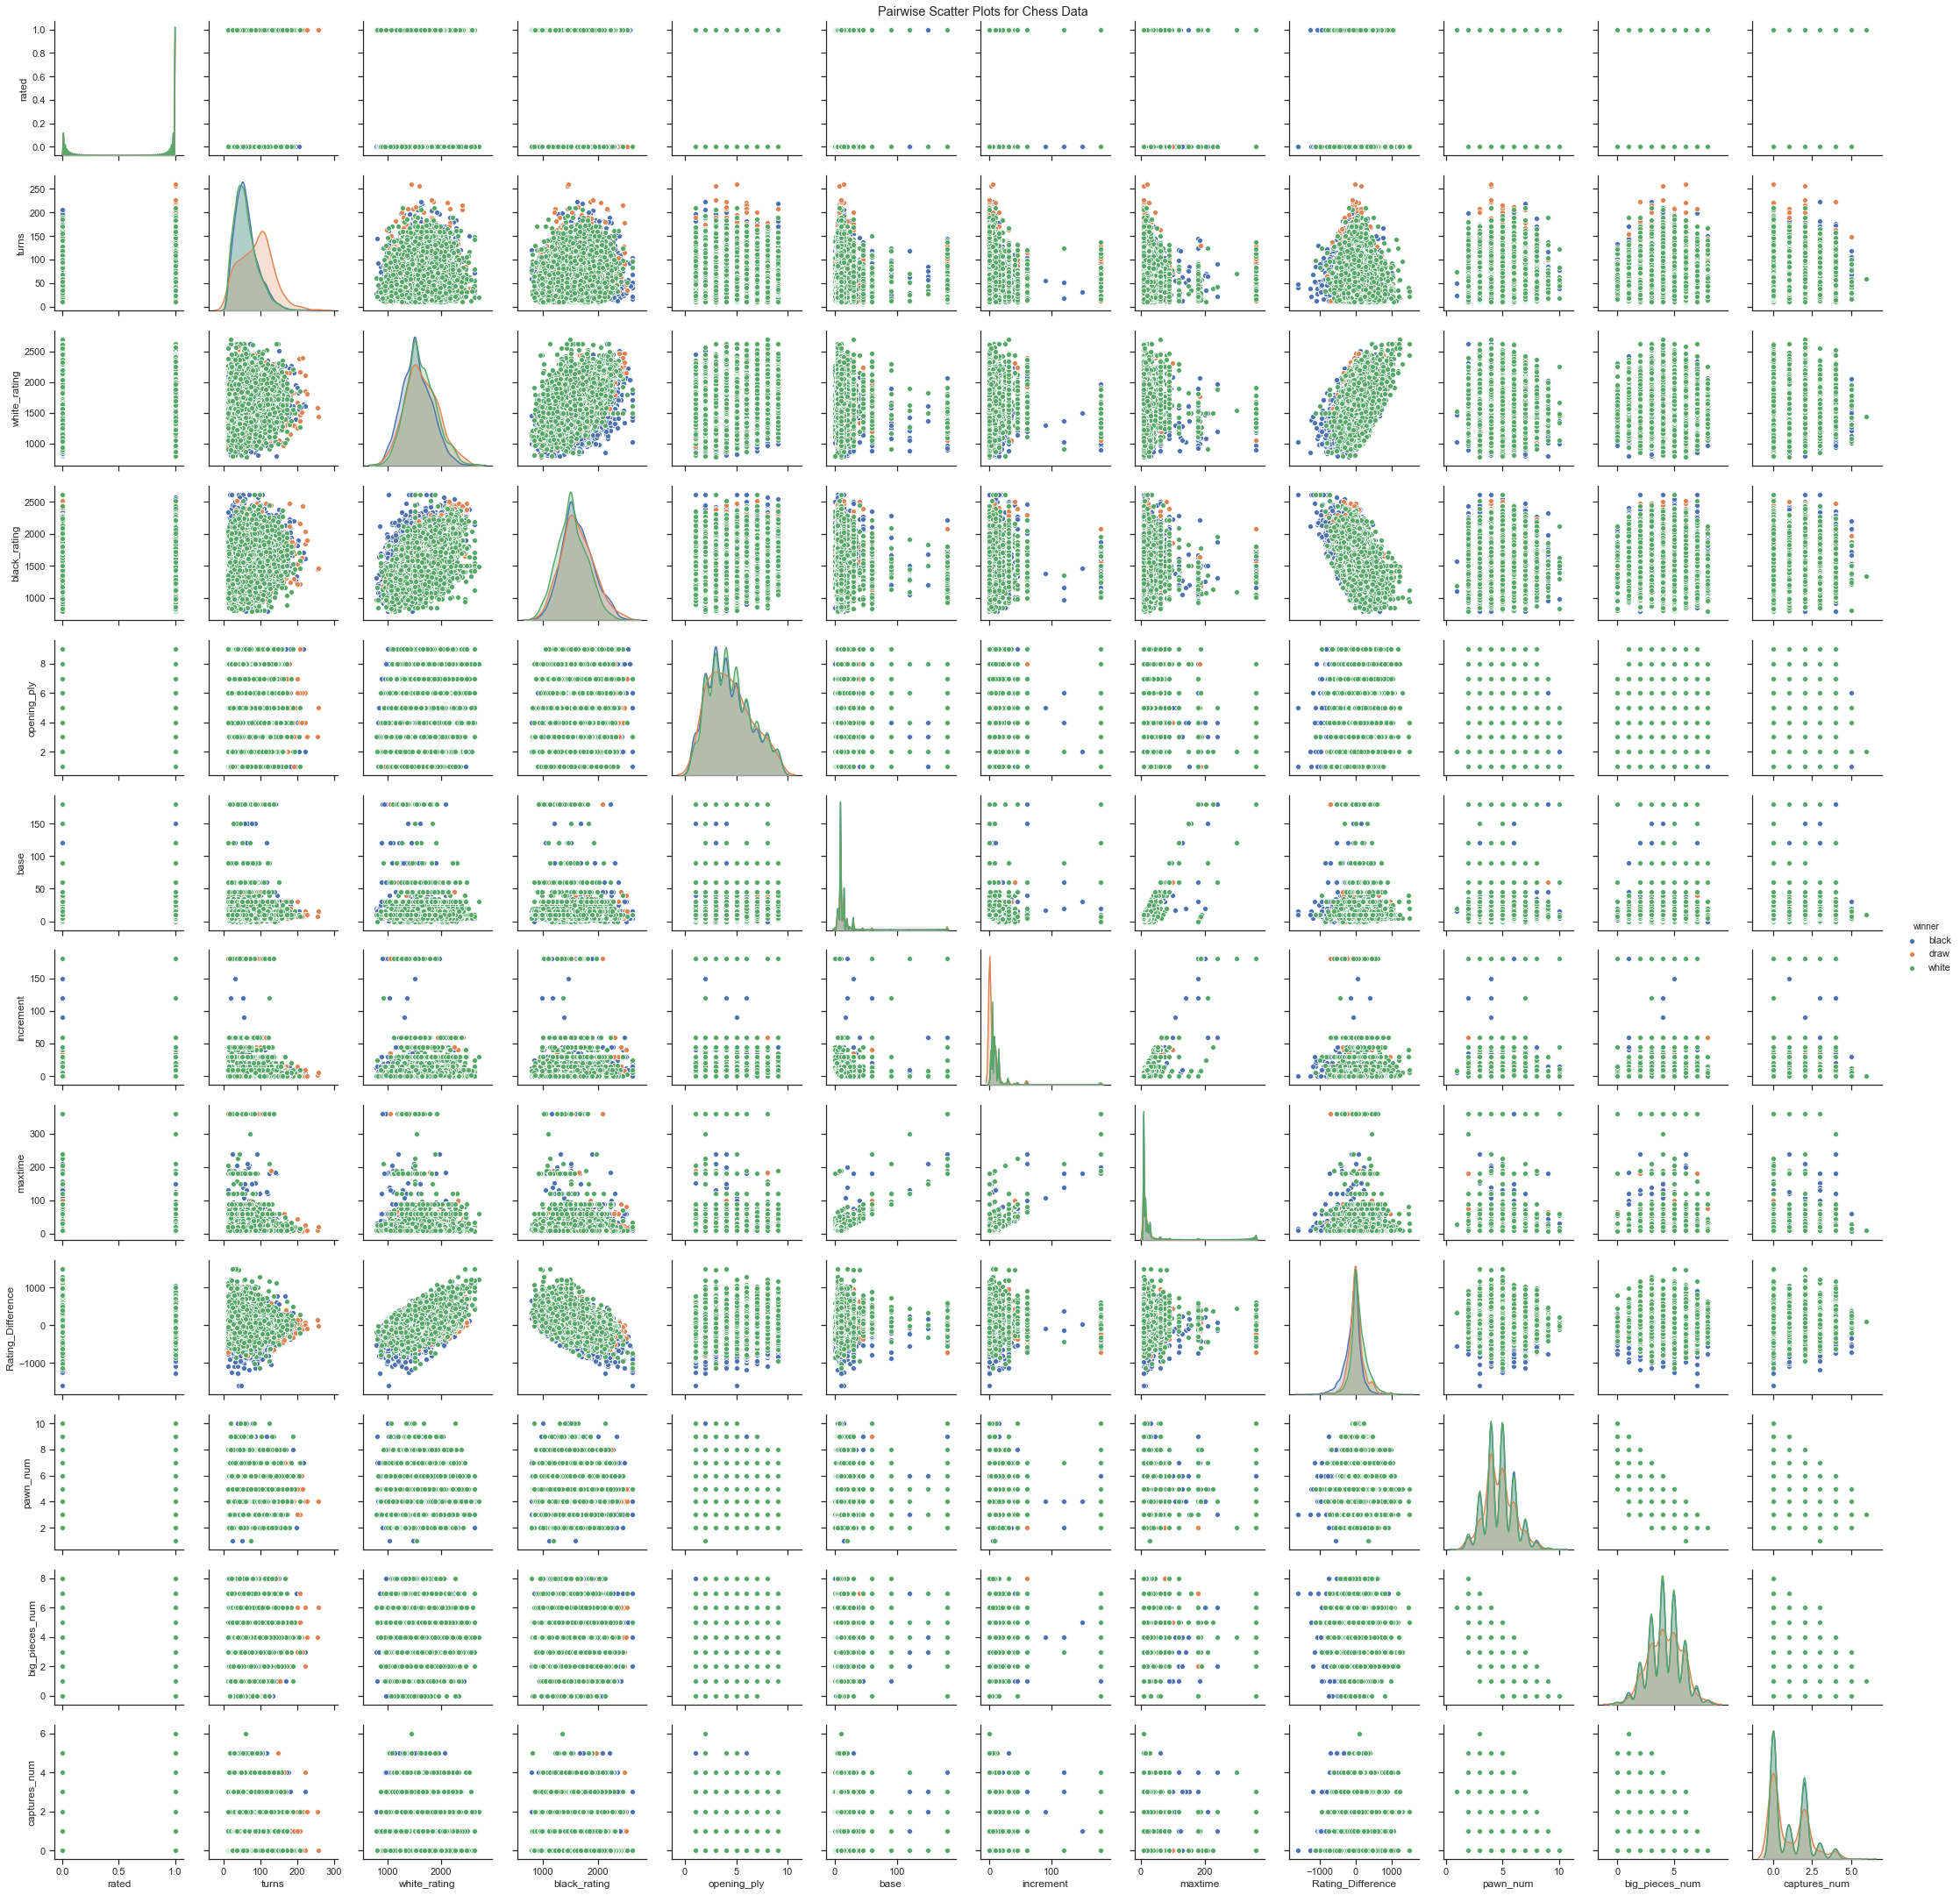

In [65]:
#pair scatter plot
import seaborn as sns
sns.set(style="ticks", color_codes=True)

chess_pd1 = pd.DataFrame(chess_pd)
chess_pd1 = remove_feature(chess_pd1, 'pawn_moves')
chess_pd1 = remove_feature(chess_pd1, 'captures_moves')
chess_pd1 = remove_feature(chess_pd1, 'big_pieces_moves')
chess_pd1 = remove_feature(chess_pd1, 'whitewin')
#chess_pd1 = chess_pd1.drop(['white_id'],axis=1)
chess_pd1 = remove_feature(chess_pd1, 'id')

chess_pd_matrix = sns.pairplot(chess_pd1,hue="winner")
chess_pd_matrix.fig.suptitle("Pairwise Scatter Plots for Chess Data",y=1)

From the white rating and black rating plot, since the plot huddle around diagonal are most darw, it shows that the players who have a close rating are more likely to end with a draw.

## Correlation Map

In [66]:
#Convert winner into numeric, prepare for the correlation map
def string_to_numeric(x):
    if x=='white':
        return 1
    if x=='draw':
        return 0
    if x=='black':
        return -1
chess_pd.winner= chess_pd.winner.apply(string_to_numeric)

Text(0.5, 1, 'Correlogram of Chess Data')

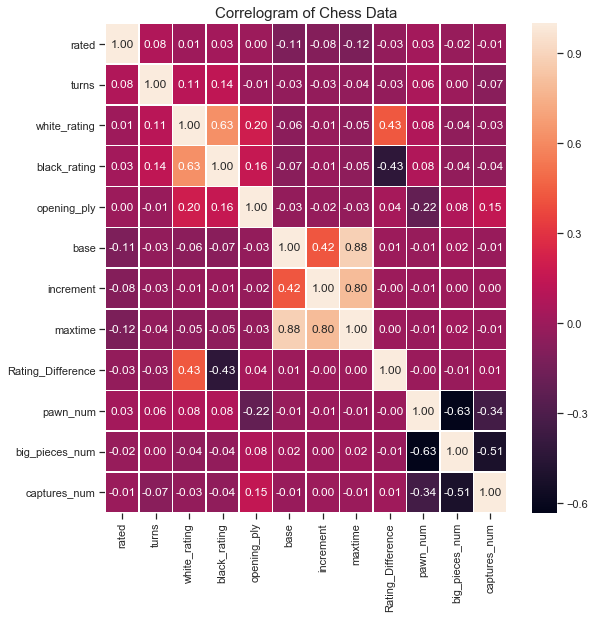

In [67]:
#Correlation map
x=chess_pd.drop(['winner'],axis=1)
f,ax = plt.subplots(figsize=(9, 9))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.title('Correlogram of Chess Data',fontsize=15)

As we see from the correlogram, we can see that the number of pawn, big piece and capture move has negative corrlationship with each other. Since we only choose the first 10 moves from opening, if nubmber of pawn is high, there aren't so many moves left for other two kinds. The white rating and black rating's correlation coefficient of 0.6, which indicates that people prefer to play with who have similar ratings.

In [68]:
#Convert winner back to string
def numeric_to_string(x):
    if x== 1:
        return 'white'
    if x== 0:
        return 'draw'
    if x== -1:
        return 'black'
chess_pd.winner= chess_pd.winner.apply(numeric_to_string)

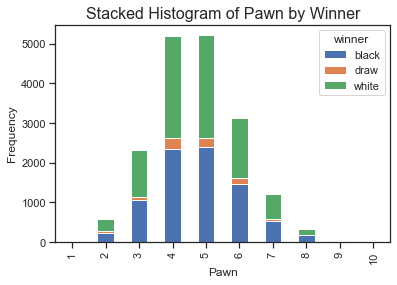

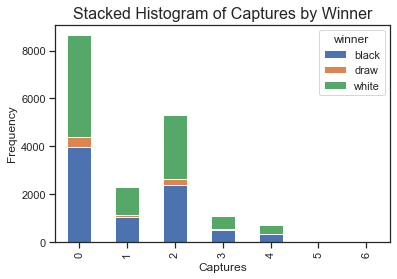

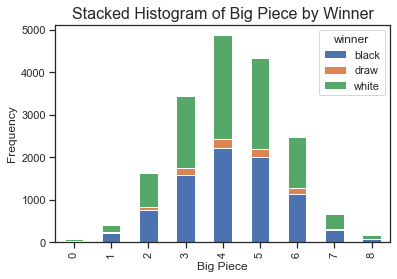

In [69]:
#code from notebook
# the cross tab operator provides an easy way to get these numbers
pawn_percentage = pd.crosstab(chess_pd['pawn_num'], # categories to cross tabulate
                       chess_pd.winner.astype(str)) # how to group
captures_percentage = pd.crosstab(chess_pd['captures_num'], # categories to cross tabulate
                       chess_pd.winner.astype(str)) # how to group
bigpieces_percentage = pd.crosstab(chess_pd['big_pieces_num'], # categories to cross tabulate
                       chess_pd.winner.astype(str)) # how to group


#plt.subplots(figsize=(20, 5))

#plt.subplot(1,3,1)

pawn_percentage.plot(kind='bar', stacked=True)
plt.title(f"Stacked Histogram of Pawn by Winner", fontsize=16)
plt.xlabel("Pawn",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

#plt.subplot(1,3,2)
captures_percentage.plot(kind='bar', stacked=True)
plt.title(f"Stacked Histogram of Captures by Winner", fontsize=16)
plt.xlabel("Captures",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

#plt.subplot(1,3,3)
bigpieces_percentage.plot(kind='bar', stacked=True)
plt.title(f"Stacked Histogram of Big Piece by Winner", fontsize=16)
plt.xlabel("Big Piece",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

The figtures above explicate that number of moves for each kind all have appropriately normal distributions. And the proportions of black win and white win are almost equal.

## P (Better Player) Winning by Maxtime

In [70]:
#let's define difference between rating function

def rating_diff(chess_pd1):
    #Test Function for generating new value
    if abs(chess_pd1['white_rating'] - chess_pd1['black_rating']) <= 100:
        return 0
    elif 100 < abs(chess_pd1['white_rating'] - chess_pd1['black_rating']) <= 200:
        return 1
    elif 200 < abs(chess_pd1['white_rating'] - chess_pd1['black_rating']) <= 300:
        return 2
    elif 300 < abs(chess_pd1['white_rating'] - chess_pd1['black_rating']) <= 400:
        return 3
    elif 400 < abs(chess_pd1['white_rating'] - chess_pd1['black_rating']) <= 500:
        return 4
    else:   
        return 5

diff_rating = chess_pd1.apply(rating_diff, axis=1)
#add diff_raing to chess_pd1 data frame
chess_pd1 = add_feature(chess_pd1, 'diff_rating', diff_rating)

In [71]:
#let's define better rater win function

def better_win(chess_pd1):
    #Test Function for generating new value
    if ((chess_pd1['white_rating'] - chess_pd1['black_rating']) > 0 and (chess_pd1['winner'] == "white")) or \
    ((chess_pd1['black_rating'] - chess_pd1['white_rating']) > 0 and (chess_pd1['winner'] == "black")):
        return 1
    else: 
        return 0

better_rater_win = chess_pd1.apply(better_win, axis=1)
#add better_rater_win to chess_pd1 data frame
chess_pd1 = add_feature(chess_pd1, 'better_rater_win', better_rater_win)
chess_pd1.head()

,rated,turns,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_ply,ten_moves,...,base,increment,maxtime,Rating_Difference,Ratings_Only_Prediction,pawn_num,big_pieces_num,captures_num,diff_rating,better_rater_win
0,False,13,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb4+]",...,15,2,17,309,white,5,2,3,3,1
1,True,16,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nxe5]",...,5,10,15,61,white,5,1,4,0,0
2,True,61,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5]",...,5,10,15,-4,black,7,3,0,0,0
3,True,61,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6]",...,20,0,20,-15,black,3,7,0,0,0
4,True,95,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6]",...,30,3,33,54,white,6,4,0,0,1


In [72]:
# make x,y plot
def get_y_values(diff, better_player_winner, maxtime, time_bin, time_min, time_max):
    '''
    Input: difference of players in category form, whether better player won
    Output: probability matrix
    '''
    num_lines = len(np.unique(diff))
    
    num_points = math.floor((time_max - time_min)/time_bin)
    num_points = int(num_points)
    
    #print(num_lines)
    #print(num_points)
    
    num_better_won = 0
    num_games = 0
    games = np.zeros([num_lines, num_points])
    better_won = np.zeros([num_lines, num_points])
    probs = np.zeros([num_lines, num_points])
    
    for idx in range(len(diff)):
        i = diff[idx] # row is difference
        #print('i' + str(i))
        
        # Check if maxtime in range
        if ((maxtime[idx] > time_min) and (maxtime[idx] < time_max)):
            j = (maxtime[idx]-time_min)/time_bin # time bin
            j = math.floor(j)
            games[i,j] += 1
            num_games += 1
            if better_player_winner[idx] == 1:
                num_better_won += 1
                better_won[i,j] += 1

   
    #print(i)
    #print(games)
    #print(better_won)
    #print(num_games)
    #print(num_better_won)
    
    for i in range(num_lines):
        for j in range(num_points):
            if games[i,j] != 0:
                probs[i,j] = float(better_won[i,j]) / float(games[i,j])
            else:
                probs[i,j] = 0
                    
    return probs


In [73]:
#Create the prob of better player win matrix
difference_rating=np.array(chess_pd1.diff_rating)
better_player_winner = np.array(chess_pd1.better_rater_win)
maxtime = np.array(chess_pd1.maxtime)
prob_betterwin = get_y_values(difference_rating, better_player_winner, maxtime, 20, 0, 100)
print(prob_betterwin)

[[0.50589547 0.50966317 0.49166667 0.36904762 0.47619048]
 [0.62834225 0.61837838 0.63235294 0.65625    0.64      ]
 [0.72931442 0.69244936 0.76190476 0.65116279 0.5       ]
 [0.80040527 0.76       0.47826087 0.67741935 0.66666667]
 [0.82993197 0.7238806  0.78571429 0.78947368 0.875     ]
 [0.86369771 0.83243243 0.76190476 0.78723404 0.71428571]]


In [74]:
prob = prob_betterwin.T
df1 = pd.DataFrame(prob, columns = ['diffwithin100', 'diff100to200','diff200to300','diff300to400',
                                   'diff400to500','diff500to600'],
                  index=['10','30','50','70', '90'])
                        #'55','60','65','70','75','80','85','90', '95'])

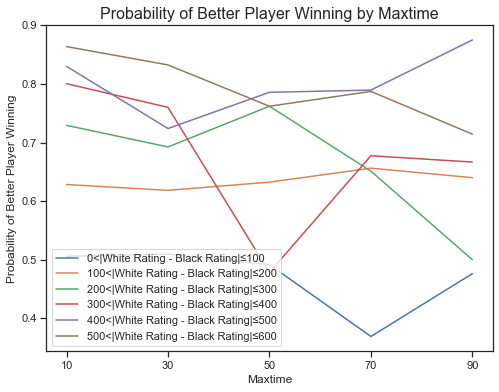

In [75]:
#Plot of Probability of Better Player Winning by Maxtime
plt.figure(figsize=(8,6))
plt.plot(df1.diffwithin100, label="0<|White Rating - Black Rating|≤100")
plt.plot(df1.diff100to200, label="100<|White Rating - Black Rating|≤200")
plt.plot(df1.diff200to300, label="200<|White Rating - Black Rating|≤300")
plt.plot(df1.diff300to400, label="300<|White Rating - Black Rating|≤400")
plt.plot(df1.diff400to500, label="400<|White Rating - Black Rating|≤500")
plt.plot(df1.diff500to600, label="500<|White Rating - Black Rating|≤600")
# Add legend
plt.legend(loc='lower left')
# Add title and x, y labels
plt.title("Probability of Better Player Winning by Maxtime", fontsize=16)
plt.xlabel("Maxtime")
plt.ylabel("Probability of Better Player Winning")
plt.show()

When the maxtime is less than 60 minutes, the better player has higher chance to win, not matter how different the players'ratings are. If the maxtime is larger than 60 minutes, the better player's advantage starts to vanish when the players have close rating, less than 100.  This is not really the graph that we expected.  We expected all of the lines to start between 50% and 70& and increase over maxtime.  The reason We thought this was because we thought that there would be more randomness when the maxtime was very short.  However, we do not really see that--most of the lines are more or less horizontal.  Thus, maxtime does not appear to have a very large affect on who is going to win.  We can see that the blue line (difference in rating less than 100_ is around 0.5 as expected.  As the difference increases, the lines move up vertically as there is a higher probability of winning for the better player.  Notably, the orange line(difference is between 100 and 200) is about exactly where it should be because the probability of the better player winning when the difference is 200 is 75%. Since the orange line is an aggregation with some differences slightly less than 200, the aggregated probability should be between 50% and 75% and we can see that it is.  The other plots are more or less horizontal with some random noise--we do not have a lot of games in the sample where there is a large rating difference between players.  But, from the blue and orange lines it looks like maxtime does not have as much of an affect as we thought.

What is possible is that some players are better at different time increment codes, but these variances at the individual level are mostly random.  For example. Fabiano Caruana and Magnus Carlsen have about the same chess rating and tied 12 times at the World Chess Championships--but it is known that Magnus Carlsen is very good when the maxtime is very short.  In essence, knowing the invidual player might be helpful in prediction, but just knowing maxtime does not appear to be a helpful feature by itself.

### Black vs White Rating Heatmap


In [76]:
import math
import numpy as np

#Calculate the prob of white win in each coloum
#Define a new variable to indicate white win
#chess_pd1 = pd.DataFrame(chess_pd)
#chess_pd1['whitewin'] = np.where(chess_pd1['winner'] == 'white', 1, 0)
#chess_pd1.info()

chess_pd2 = pd.DataFrame(chess_pd)
chess_pd2['whitewin'] = np.where(chess_pd['winner'] == 'white', 1, 0)
chess_pd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 23 columns):
rated                      18047 non-null bool
turns                      18047 non-null int64
winner                     18047 non-null category
increment_code             18047 non-null object
white_rating               18047 non-null int64
black_rating               18047 non-null int64
moves                      18047 non-null object
opening_eco                18047 non-null object
opening_ply                18047 non-null int64
ten_moves                  18047 non-null object
opening_category           18047 non-null object
base                       18047 non-null int64
increment                  18047 non-null int64
maxtime                    18047 non-null int64
Rating_Difference          18047 non-null int64
Ratings_Only_Prediction    18047 non-null object
pawn_num                   18047 non-null int64
big_pieces_num             18047 non-null int64
captures_num       

In [77]:
def ratings_heatmap(min_v, max_v, bin_size, white_rating_hm, black_rating_hm, win_hm):
    '''
    Input: minimum value in array, maximum value, list of white ratings, 
    list of black ratings
    Output: nxn array where n is (maximum - minimum)/bin_size
    '''
    # create matrix
    n = (max_v-min_v)/(bin_size)
    n = int(math.floor(n))
    num_games = np.zeros((n,n))
    num_white = np.zeros((n,n))
    prob_heat_map = np.zeros((n,n))
    
    # classify each game
    for idx in range(len(black_rating_hm)):        
        
        i = ((black_rating_hm[idx]) - min_v)/(bin_size)
        j = ((white_rating_hm[idx]) - min_v)/(bin_size)
        if ((black_rating_hm[idx]) > min_v) and ((black_rating_hm[idx]) < max_v):
            if ((white_rating_hm[idx] > min_v) and (white_rating_hm[idx] < max_v)):
                i = ((black_rating_hm[idx]) - min_v)/(bin_size)
                j = ((white_rating_hm[idx]) - min_v)/(bin_size)
                i = math.floor(i)
                j = math.floor(j)
        
                num_games[i,j] += 1
                if (win_hm[idx] == 1):
                    num_white[i,j] += 1
    for i in range(n):
        for j in range(n):
            prob_heat_map[i,j] = num_white[i,j]/num_games[i,j]
            
    return prob_heat_map

In [78]:
white_rating = chess_pd2.white_rating.to_numpy()
black_rating = chess_pd2.black_rating.to_numpy()
min_v = 1000
max_v = 2000
bin_size = 200
white_win = chess_pd2.whitewin.to_numpy()
#print(len(white_rating))
#print(len(black_rating))
#print(len(white_win))
#print(white_win)
#print(black_rating)
prob_hm = ratings_heatmap(min_v, max_v, bin_size, white_rating, black_rating, white_win)
print(prob_hm)                          
             

[[0.47311828 0.69211196 0.84444444 0.85416667 0.94871795]
 [0.31188119 0.50142857 0.64712154 0.809375   0.82882883]
 [0.28506787 0.35027027 0.50507614 0.62632085 0.75830816]
 [0.10280374 0.16498316 0.33120341 0.49882214 0.62652439]
 [0.11538462 0.20792079 0.23357664 0.36515913 0.47826087]]


In [79]:
# Make Pretty Plot
def plot_prob(prob_hm, title, row_labels, column_labels):
    '''
    Input: board
    Output: heatmap plot
    '''
    # Following two lines taken from seaborn documentation
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    heatmap_df = pd.DataFrame(prob_hm, columns = column_labels, index = row_labels)
    ax = sns.heatmap(heatmap_df, linewidth = 0.5, square = True)
    plt.title(title)
    plt.ylabel('Black Rating')
    plt.xlabel('White Rating')
    
    #plt.show()
#row_labels = ['1100', '1300', '1500', '1700', '1900']
#column_labels = ['1100', '1300', '1500', '1700', '1900']
#row_labels = range(5)
#column_labels = range(5)

#title = "Probability of White winng of Black Rating vs White Rating"
#plot_prob(prob_hm, title, row_labels, column_labels)


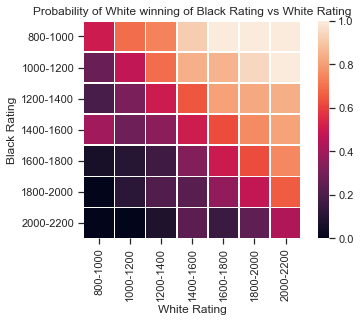

In [80]:
white = chess_pd2.white_rating.to_numpy()
black = chess_pd2.black_rating.to_numpy()
min_v = 800
max_v = 2200
bin_size = 200
win = chess_pd2.whitewin.to_numpy()
#print(len(white))
#print(len(black))
#print(len(win))

prob_hm = ratings_heatmap(min_v, max_v, bin_size, white, black, win)
#print(prob_hm)


row_labels = ['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200']
column_labels = ['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200']
title = "Probability of White winning of Black Rating vs White Rating"
plot_prob(prob_hm, title, row_labels, column_labels)
                       

This graph is light where white has a high probability of winning and dark where black has a high probability of winning.  From this graph, we can see that the outcome can be predicted with a lot of accuracy when black and white do not have the same rating.  When they have about the same rating, then the probability of white winning is about 1/2 which is exactly what we expected.  We aggregated the rating into groups of 200 because that is the size of different Classes such as Class A, Class B, Class C, and Class D.  A category is only 25 points wide, but that would make the graph look too spotty as there is not enough data in each group.

### Black Rating vs White Rating Histogram

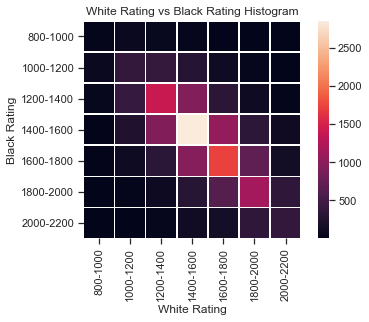

In [81]:
def create_white_vs_black_hist(white_rating_hm, black_rating_hm, bin_size, min_v, max_v):
    '''
    Input: white rating, black rating, bin_size, minimum/maximum rating
    Output: white vs black histogram
    '''
    
    n = (max_v-min_v)/(bin_size)
    n = int(math.floor(n))
    num_games = np.zeros((n,n))
    
    for idx, val in enumerate(white_rating_hm):
        # check minimum, maximum
        if ((black_rating_hm[idx] > min_v) and (black_rating_hm[idx] < max_v)):
            if ((white_rating_hm[idx] > min_v) and (white_rating_hm[idx] < max_v)):
                i = ((black_rating_hm[idx]) - min_v)/(bin_size) 
                j = ((white_rating_hm[idx]) - min_v)/(bin_size)
                i = math.floor(i)
                j = math.floor(j)
        num_games[i][j] += 1
    return num_games



def plot_white_vs_black_hist(num_games, title, row_labels, column_labels):
    '''
    Input: num_games np array, title, row/column labels
    Output: heatmap
    '''
    heatmap_df = pd.DataFrame(num_games, columns = column_labels, index = row_labels)
    ax = sns.heatmap(heatmap_df, linewidth = 0.5, square = True)
    plt.title(title)
    plt.ylabel('Black Rating')
    plt.xlabel('White Rating')

white = chess_pd2.white_rating.to_numpy()
black = chess_pd2.black_rating.to_numpy()
min_v = 800
max_v = 2200
bin_size = 200

num_games = create_white_vs_black_hist(white, black, bin_size, min_v, max_v)
title = 'White Rating vs Black Rating Histogram'
row_labels = ['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200']
column_labels = ['800-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200']
plot_white_vs_black_hist(num_games, title, row_labels, column_labels)    

From this graph, we see that most of the games occur between players with a rating of 1500; this makes sense as this is the default value when you start at Lichess.com. Thus, we should be careful about games in this square because the rating may or may not be the true rating of the player. Also, most games occur between players of similar rating.

Text(0.5, 0, 'Number of Opening Play')

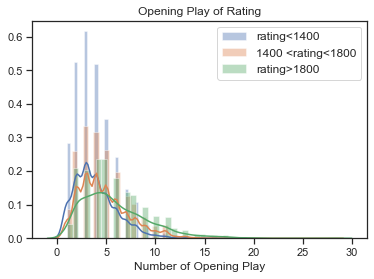

In [82]:
chess_original_8 = chess_original

## This code is taken from website
#https://chrisalbon.com/python/data_wrangling/pandas_create_column_with_loop/
rating = []
for row in chess_original_8['white_rating']:
    if row <= 1400:
        rating.append('0')
    elif 1400 < row < 1800:
        rating.append('1')
    elif row >= 1800:
        rating.append('2')
chess_original_8['rating'] = rating

#This code is taken from website
#https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/
df = chess_original_8[chess_original_8['rating'] == '0']
sns.distplot(df['opening_ply'],  kde=True, label='rating<1400')
df = chess_original_8[chess_original_8['rating'] == '1']
sns.distplot(df['opening_ply'],  kde=True, label='1400 <rating<1800')
df = chess_original_8[chess_original_8['rating'] == '2']
sns.distplot(df['opening_ply'],  kde=True, label='rating>1800')
plt.legend(prop={'size': 12})
plt.title('Opening Play of Rating')
plt.xlabel('Number of Opening Play')

This is a visualization of how long the opening classification is based on player rating.  Our prediction was that higher rated players would have longer openings on average and we can see that this is true. Lower-rated players have very short openings with a huge peak at aroun 4-5 moves.  As the rating of the players improve, however, the distribution flattens out as they begin to use longer opening move sequences.

# Exceptional Work - t-SNE (10 points total)


## t-SNE Explanation

T-SNE, also known as t-distributed stochastic neighbor embedding (t-SNE), is a non-linear unsupervised technique to achieve dimensionality reduction. T-SNE attempts to preserve the structure of the high dimensional space in lower dimensions by preserving local distances.  The classic example is that of the spiral or other curved manifold. T-SNE will “follow the spiral.”  T-SNE uses a probability distribution over pairs of points Pij where if i and j are close together Pij is larger and if i and j are far apart then Pij is small.  


There are three steps to the t-SNE Algorithm.
The first step is to calculate the similarity points in the original (high) dimension and the target (low) dimensional spaces.

The following equation is used to calculate the probabilities in high dimensional map.
$$P_{j|i} = \frac{exp(-\left \| x_{i}-x_{j} \right \|^{2} /2\sigma ^{2})}{\Sigma _{k}\Sigma _{i\not\equiv j} exp(-\left \| x_{i}-x_{j}  \right \|^{2} /2\sigma ^{2})}$$
Equation taken from Laurens van der Maaten's Google Tech talk https://www.youtube.com/watch?v=RJVL80Gg3lA

The numerator is simply the Gaussian. The denominator is made specifically for the i,j points as a way of 'scaling.'  Thus, if in some parts of the high-dimensional manifold are more dense than others parts, the points that are most similar in high dimensional space will appear thesame distance apart in the visualization.  The last step is to average $P_{i|j}$ and $P_{j|i}$ and divide by 2N.

The following equation is used to calculate the conditional probabilities in the low dimensional map.
$$q_{i,j} = \frac{(1+\left \| y_{i}-y_{j} \right \|^{2})^{-1}}{\Sigma _{k}\Sigma _{t\not\equiv k} (1+\left \| y_{k}-y_{l} \right \|^{2})^{-1} }$$

Note that in the above equation we use the Student-t distribution but not a Gaussian.  This is because points that are far away might have to become further away in the lower dimensional space to preserve local distances. Since the Student-T distribution has a heavier tail, the distribution allows for points to be further away in the lower dimensional visualization. 

Last, we must measure how well the distances are conserved in the low-dimensional space vs. the high dimensional space. In other words, we need to minimize the divergence.  To do this, we will use the Kullback-Leibler Divergence:

$$ KL(P||Q) =  \sum_{i} \sum_{j\neq i} p_{ij} log\frac{p_{ij}}{q_{ij}}  $$

This is used because if there is large $p_{ij}$ (points are close together in high dimensional space) then they should have a high $q_{ij}$.  But on the other hand, if there is a small $p_{ij}$ (high dimensional space objects are far apart), then the algorithm doesn't care if they are put together in low dimensional space.  Thus, the algorithm tries to maintain local distances.  Finally, we use gradient descent to find the(a) minimum value.

To make the algorithm run faster(nlog(n) vs. $n^{2}$, he uses the Barnes-Hut approximation.  This approximation treats points that are far away as a single point at the center of mass.   Notably, this approximation is used by astronomers.  He uses a quadtree to implement this approximation.  With this approximation, he can look at larger datasets.


## Citations for t-SNE

Chang, R. (2019). What advantages does the t-SNE algorithm have over PCA?. [online] Quora.com. Available at: https://www.quora.com/What-advantages-does-the-t-SNE-algorithm-have-over-PCA [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). Kullback–Leibler divergence. [online] Available at: https://en.wikipedia.org/wiki/Kullback–Leibler_divergence [Accessed 14 Sep. 2019].

Pathak, M. (2019). Introduction to t-SNE. [online] DataCamp Community. Available at: https://www.datacamp.com/community/tutorials/introduction-t-sne [Accessed 14 Sep. 2019].

van der Maaten, L. (2019). t-SNE. [online] Laurens van der Maaten. Available at: https://lvdmaaten.github.io/tsne/ [Accessed 14 Sep. 2019].

van der Maaten, L. (2019). Visualizing Data Using t-SNE. [online] YouTube. Available at: https://www.youtube.com/watch?v=RJVL80Gg3lA [Accessed 14 Sep. 2019].

van der Maaten, L. and Hinton, G. (2019). Visualizing Data using t-SNE. [online] Jmlr.org. Available at: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf [Accessed 14 Sep. 2019].

## t-SNE Code Taken from 
https://www.datacamp.com/community/tutorials/introduction-t-sne


In [83]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE

# Parameters that can be "tuned"

# angle have been changed from default values;
# make it run faster by having angle above 0.8

n_components1 = 2 # dimension of visualization should be 2 for 2-D 
perplexity1 = 30.0 # Related to number of nearest neighbors considered. Recommended to choose between 5 and 50.
early_exaggeration1 = 12.0 # controls density
learning_rate1 = 200.0 #in range 10-1000 (https://www.datacamp.com/community/tutorials/introduction-t-sne)
n_iter1 = 1000 # maximum number of iterations
n_iter_without_progress1 = 300 # number of iterations before aborted
min_grad_norm1 = 1e-07 # if gradient norm < min_grad_norm, the visualization is considered to reach the minimum value
metric1 = 'euclidean' # doesn't have to be euclidean
init1 = 'random' #initial state of embedding. PCA results in a more stable result
verbose1 = 0
random_state1 = None
method1 = 'barnes_hut' # uses the barnes-hut approximation as described above to run faster
angle1 = 0.9 # trade-off between accuracy and error for barnes_hut. If less than 0.2 slower but more accurate

In [84]:
# run T-SNE
def get_numeric_dataframe(dataframe):
    """
    input: dataframe, feature
    output: dataframe with only numeric columns
    """
    for name in dataframe.columns:
        if (str(type(name)) != "<class 'numpy.float64'>") and \
        (str(type(name)) != "<class 'numpy.int64'>"):
            dataframe.drop(name)
    return dataframe

X_train = chess_tsne
Y_train = chess_pd.winner

print(chess_tsne.head())

   white_rating  black_rating  opening_ply  False  True  black  draw  white  \
0          1500          1191            5      1     0      0     0      1   
1          1322          1261            4      0     1      1     0      0   
2          1496          1500            3      0     1      0     0      1   
3          1439          1454            3      0     1      0     0      1   
4          1523          1469            5      0     1      0     0      1   

   A  B  C  D  E  base  increment  maxtime  
0  0  0  0  1  0    15          2       17  
1  0  1  0  0  0     5         10       15  
2  0  0  1  0  0     5         10       15  
3  0  0  0  1  0    20          0       20  
4  0  0  1  0  0    30          3       33  


In [85]:
#Y_train = X_train['winner']    
    
# Use only numeric data
#X_train = remove_feature(X_train, 'winner')

#X_train = chess_pd.to_numpy()


#X_train, y_train = load_mnist('Downloads/datasets/mnist/fashion_mnist', kind='train') 
tsne_model = TSNE(n_components = n_components1, perplexity = perplexity1, early_exaggeration = early_exaggeration1, \
                  learning_rate = learning_rate1, n_iter = n_iter1, \
                  n_iter_without_progress = n_iter_without_progress1, \
                  min_grad_norm = min_grad_norm1, metric = metric1, init = init1, \
                  verbose = verbose1, random_state = random_state1, method = method1, \
                  angle = angle1).fit_transform(X_train)

### Default Parameters

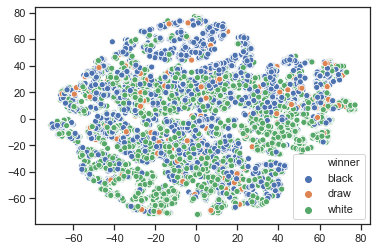

In [86]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

With the default parameters, we see that we do not get separation based on white, black and draw with the exception of a blue area in the upper right hand corner.  However, from reading about t-SNE, we know that if we tune the parameters we might get very different plots. So, we tries tuning perplexity (related to number of nearest neighbours) and angle (related to how accurate of an approximation to use).  We also trie using pca as the initialization for the embedding just to see how these parameters change the graph.

### Perplexity = 10 

In [87]:
tsne_model=TSNE(init = "random", perplexity=10).fit_transform(X_train)

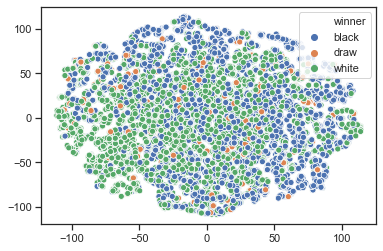

In [88]:
sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

With a low perplexity the group forms a big blob as the groups do not separate.  Thus to form different groups using unsupervised learning we will need to use a larger perplexity.  In this data though you can see that the greeen is separated from the blue a little bit.  On average green is more lower left and blue is more lower reight.  However, you could not write a very good classification algorithm using just this plot.  The white/black/draw data are too mixed together.

### Perplexity = 50

In [89]:
tsne_model=TSNE(init = 'pca', perplexity=50).fit_transform(X_train)

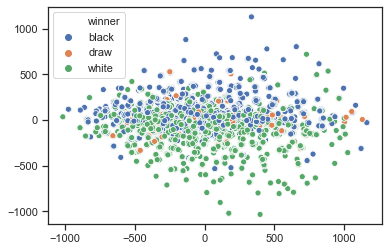

In [90]:
sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

This is a graph using PCA. Again, the PCA does separate white/black/draw extremely well.  However, this doesn not really fulfill the goals of the assignment as starting with PCA is almost cheating.  To fulfill the goals of the assignment, we will try to obtain a good graph with a random start to the embedding and see if the algorithm can find meaningful categories completely unsupervised.

### Perplexity 50

In [91]:
tsne_model = TSNE(perplexity= 50).fit_transform(X_train)

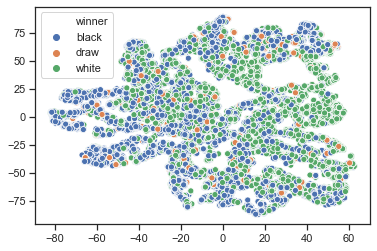

In [92]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

When Perplexity is 10, there are more categories and you can begin to see blue on the top and green generally on the bottom.  HOwever, it still does not look like a graph that tells us much about black, white and draw.

### Perplexity = 100, Angle = 0.2

In [ ]:
tsne_model=TSNE(init = "random", perplexity=100,angle=0.2).fit_transform(X_train)

In [ ]:

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity 10, Init is PCA

In [93]:
tsne_model = TSNE(perplexity= 10, init = 'pca').fit_transform(X_train)

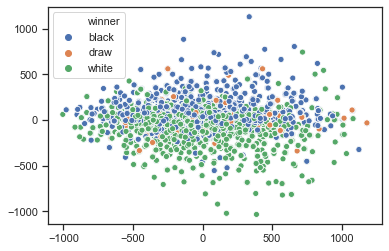

In [94]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

Here is our second PCA graph.  We see that PCA successfully separated white, black, and draw pretty well.  From looking at many graphs, we can see that this graph is dominated by the pca initialization.  In this case, the perplexity of 10 does not matter as much.

### Perplexity of 20, PCA

In [95]:
tsne_model = TSNE(perplexity= 20, init = 'pca').fit_transform(X_train)

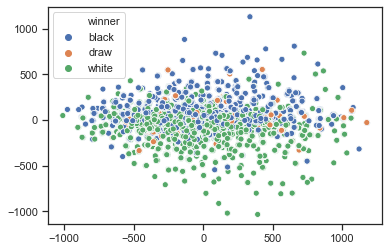

In [96]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

As you can see form the above graph, when pca is used the graphs all loook very similar. You cannot see much difference between the perplexity. 

In [97]:
tsne_model = TSNE(perplexity= 40, init = 'pca').fit_transform(X_train)

### Perplexity = 40, PCA

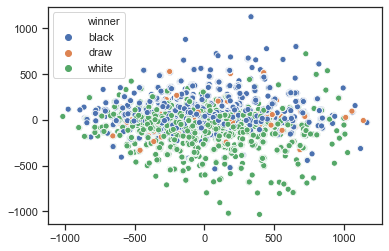

In [98]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

Here is another PCA graph with a higher perplexity. Again, we can see that the perplexity does not make that big of a difference when the initial starting position is PCA.

### Perplexity 40, default other parameters

In [99]:
tsne_model = TSNE(perplexity= 40).fit_transform(X_train)

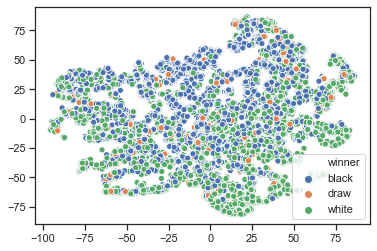

In [100]:
# code taken from https://towardsdatascience.com/t-sne-python-example-1ded9953f26

sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

Here is graph with perplexity = 40.  To be honest, it does not look to have separated into noticeable categories at all.  We will try some more parameters to see what we get.

### PCA, Perplexity = 30, angle = 0.15

In [101]:
tsne_model=TSNE(init = 'pca', angle = 0.15).fit_transform(X_train)

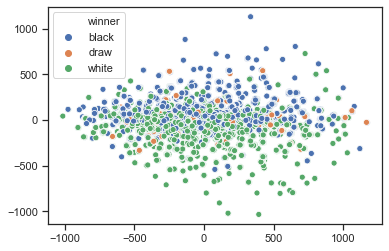

In [102]:
sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Plots that we tried but didn't think were that great

### PCA, Perplexity = 30, angle = 0.15, PCA

In [ ]:
#tsne_model=TSNE(init = 'pca', angle = 0.15, perplexity=20).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### PCA, Perplexity = 50, PCA

In [ ]:
#tsne_model=TSNE(init = 'pca', perplexity=50).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 10

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=10).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 50

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=50).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 50

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=40).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 50, Angle = 0.2

In [ ]:
#tsne_model=TSNE(init = "random", angle=0.2, perplexity=50).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 100, Angle = 0.8

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=100,angle=0.8).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 100

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=100).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 2

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=2).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 2, modified data set

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=2).fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 100, modified data set

In [ ]:
#tsne_model=TSNE(init = "random", perplexity=100).fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 30, modified data set

In [ ]:
#tsne_model=TSNE(init = "random").fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 2, PCA, modified data set

In [ ]:
#tsne_model=TSNE(init = "pca",perplexity=2).fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 100, PCA, modified data set

In [ ]:
#tsne_model=TSNE(init = "pca",perplexity=100).fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 100, angle = 0.15, modified data set

In [ ]:
#tsne_model=TSNE(init = "random",perplexity=100, angle=0.15).fit_transform(X_train_2)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

### Perplexity = 2, angle = 0.15

In [ ]:
#tsne_model=TSNE(init = "random",perplexity=2, angle=0.15).fit_transform(X_train)

In [ ]:
#sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

# How parameters change the graph
Pca: pca will substantially change the distance between each points comparing to using a random initial state.

Perplexity: a smaller perplexity will make the points look more separated while a larger perplexity make them clustered.

Angle: Angle will change the direction of the whole plot. Also, angle smaller than 0.2 will largely increase the computation time. Time can be fourfold when you change angle from the default 0.5 to 0.15.

### t-SNE Conclusion and best t-SNE Graph


In [ ]:
tsne_model=TSNE(init = "random",perplexity=100, angle=0.2).fit_transform(X_train)

In [ ]:
sns.scatterplot(tsne_model[:,0], tsne_model[:,1], hue=Y_train, legend='full')

This graph looks pretty good as we can see that three groups are clearly separated to each other, with the white winner group mostly distributed at the left upper corner of the graph while the black winner mostly distributed at the right bottom corner. Also, angle = 0.2 can greatly increase the accuracy of the prediction since we know that a large angle can reduce the accuracy as a sacrifice.